In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import glob as gb
from tqdm import tqdm
import pandas as pd
from skimage.io import imread
from sklearn.metrics import accuracy_score

D:\anconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
train_dir='./train/'
X_train1=[]
y_train1=[]


for folder in os.listdir(train_dir):
    img=cv2.imread(train_dir+folder+'/images/'+folder+'.jpeg')
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img=cv2.resize(img,(256,256))
    X_train1.append(img)
    name = os.listdir(train_dir+folder+'/masks/')[0]
    img=cv2.imread(train_dir+folder+'/masks/'+name)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img=cv2.resize(img,(256,256))
    y_train1.append(list(img))


X_train=np.array(X_train1)
y_train=np.array(y_train1, dtype=bool)

In [3]:
print(np.shape(X_train),
np.shape(y_train))

(1100, 256, 256) (1100, 256, 256)


In [4]:
test_dir='./test/'
X_test=[]

for folder in os.listdir(test_dir):
    img=cv2.imread(test_dir+folder+'/images/'+folder+'.jpeg')
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img=cv2.resize(img,(256,256))
    X_test.append(list(img))

X_test=np.array(X_test)
np.shape(X_test)

(359, 256, 256)

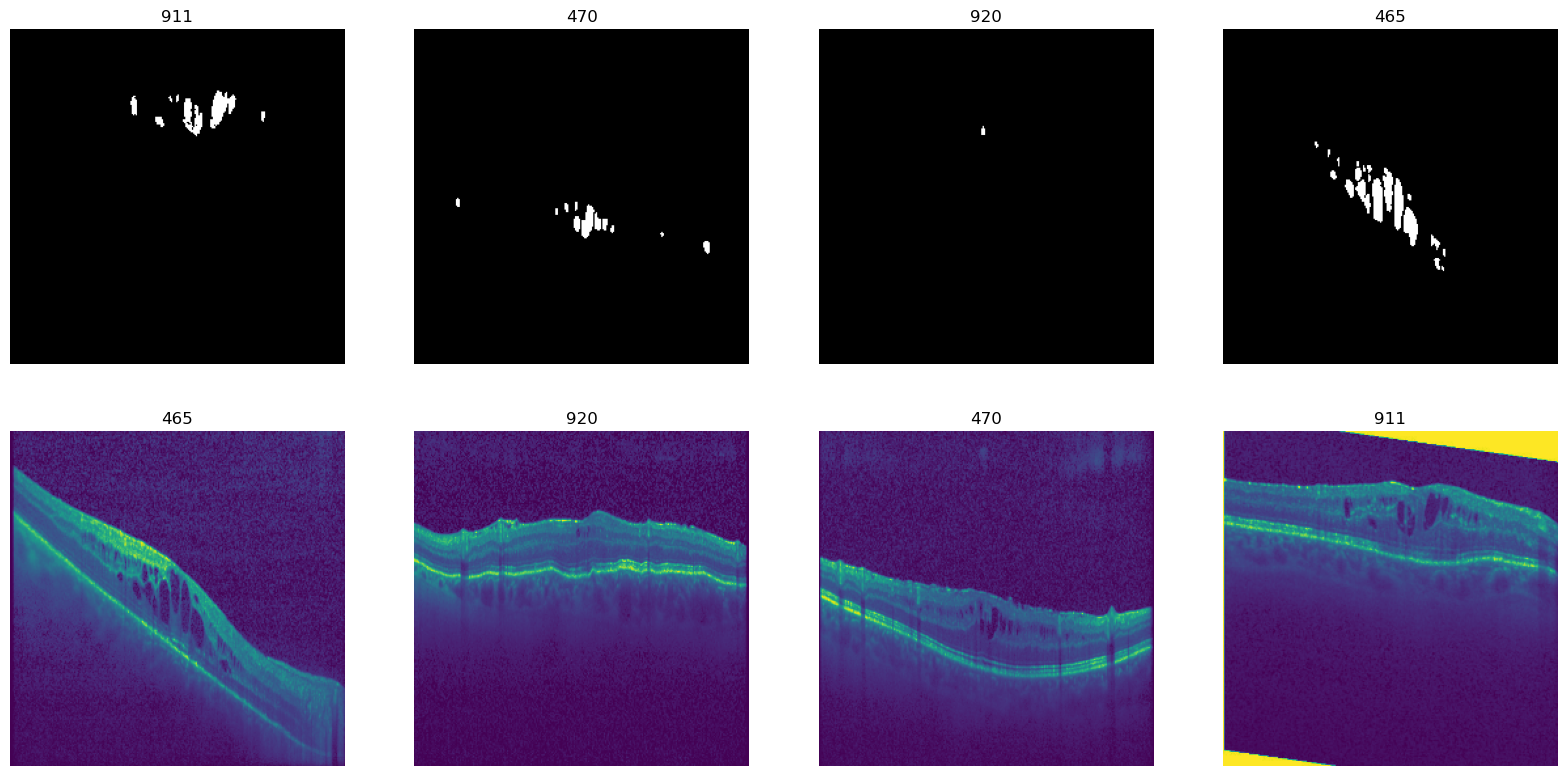

In [5]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_train),8))) :
    plt.subplot(4,4,n+1)
    plt.imshow(X_train[i])
    plt.title(i)
    plt.subplot(4,4,8-n)
    plt.imshow(y_train[i],cmap='gray')
    plt.title(i)
    plt.axis('off')

In [6]:
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid=train_test_split(X_train,y_train,test_size=0.1)

In [7]:

from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Conv2D , MaxPooling2D ,concatenate ,Input ,Dropout ,UpSampling2D
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint ,TensorBoard

In [8]:
import tensorflow as tf

In [9]:

from tensorflow.keras import layers, models

def unet_model(input_shape=(256, 256, 1), num_classes=1):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = layers.concatenate([up5, conv3], axis=-1)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = layers.concatenate([up6, conv2], axis=-1)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = layers.concatenate([up7, conv1], axis=-1)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(conv7)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Create the U-Net model
model = unet_model()

# Compile the model (you can customize the optimizer, loss, and metrics)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()





Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                        

In [12]:

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_valid, y_valid))

ValueError: Data cardinality is ambiguous:
  x sizes: 990
  y sizes: 64880640
Make sure all arrays contain the same number of samples.